In [1]:
%matplotlib inline
import caffe
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

OPENPOSE_DIR = 'openpose'
caffe.set_mode_gpu()
caffe.set_device(0)
net = caffe.Net(OPENPOSE_DIR + '/models/pose/coco/pose_deploy_linevec.prototxt',
                OPENPOSE_DIR + '/models/pose/coco/pose_iter_440000.caffemodel', caffe.TEST)

In [2]:
def preproc(image):
    image = image/256. - 0.5
    image = np.transpose(image[:, :, [2, 1, 0]], [2, 0, 1])
    return image
    

def estimate_keypoints(image):
    image = image[np.newaxis]
    net.blobs['image'].reshape(*image.shape)
    net.blobs['image'].data[...] = image[np.newaxis]
    net.forward()
    
    pred_keys = ['conv5_5_CPM_L2', ] + ['Mconv7_stage{}_L2'.format(i) for i in range(2, 7)]
    pred_maps = OrderedDict([(k, net.blobs[k].data[0]) for k in pred_keys])
    return pred_maps

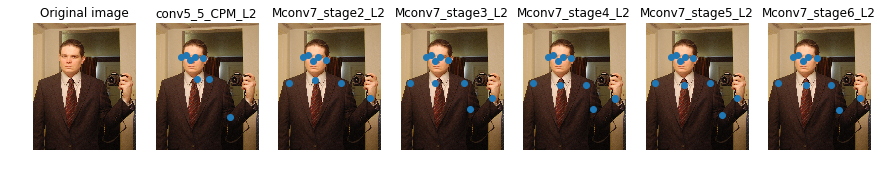

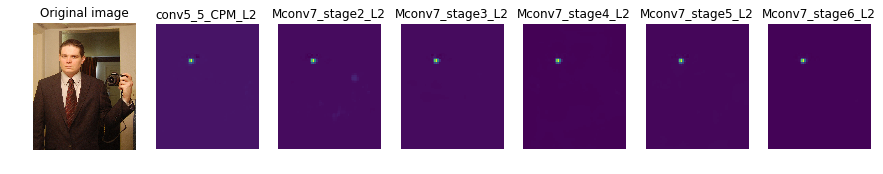

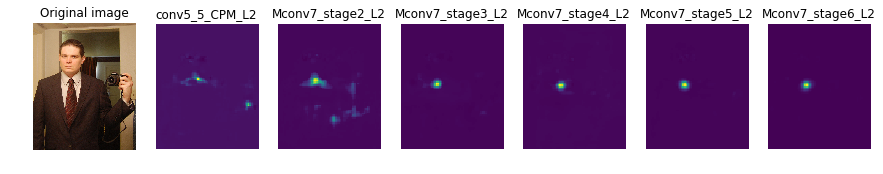

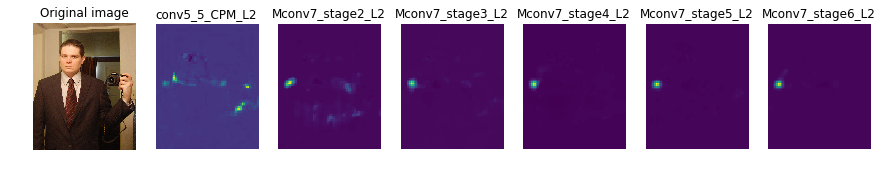

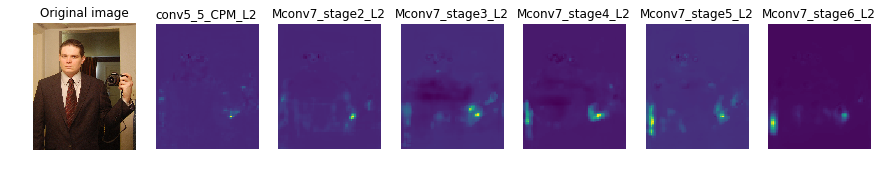

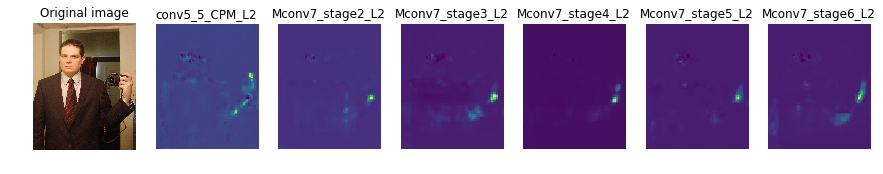

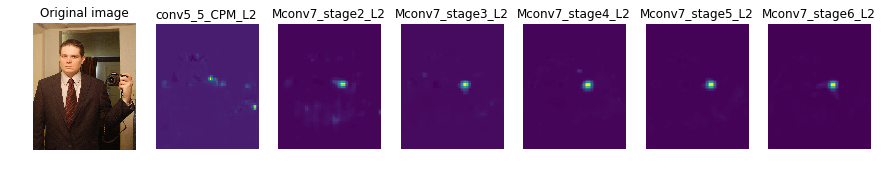

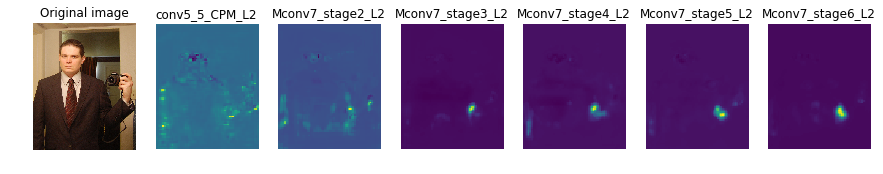

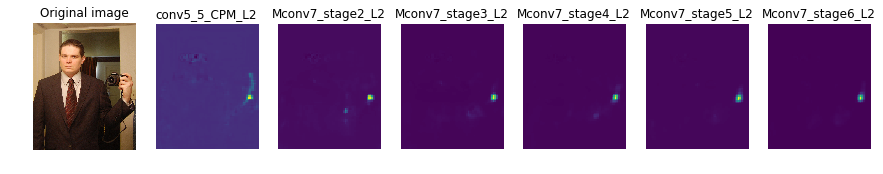

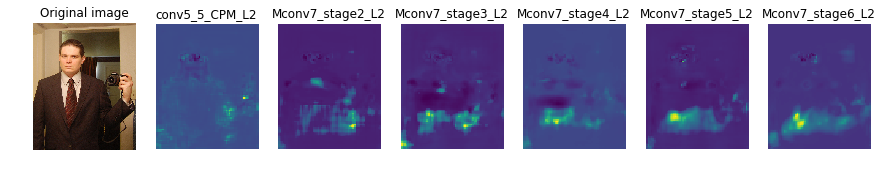

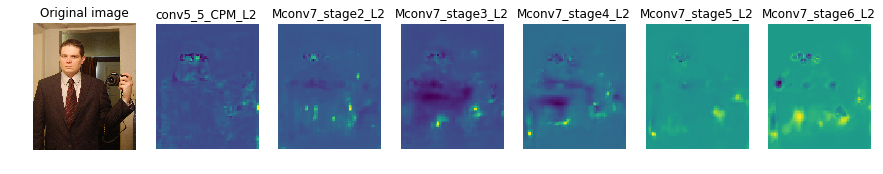

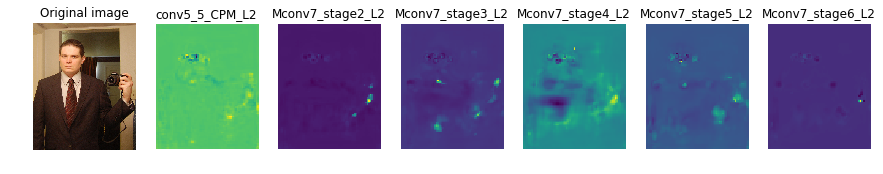

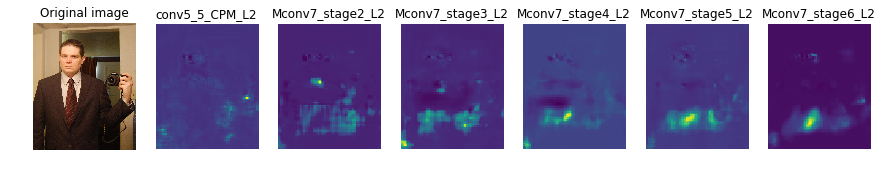

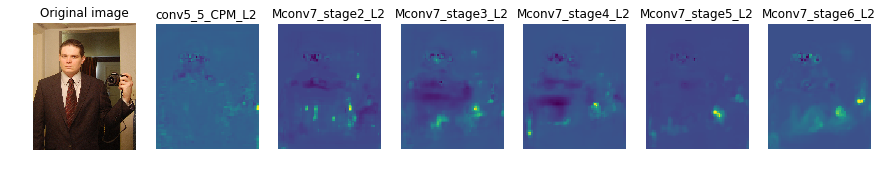

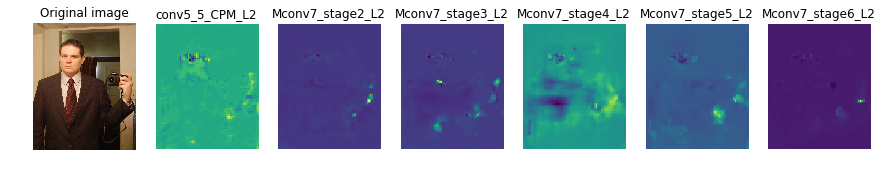

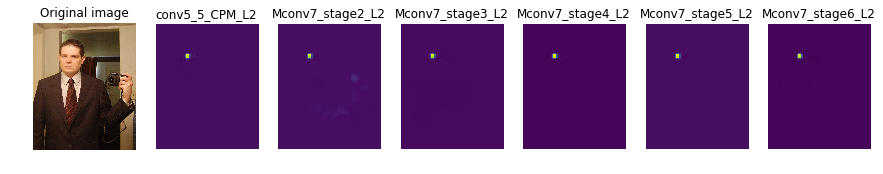

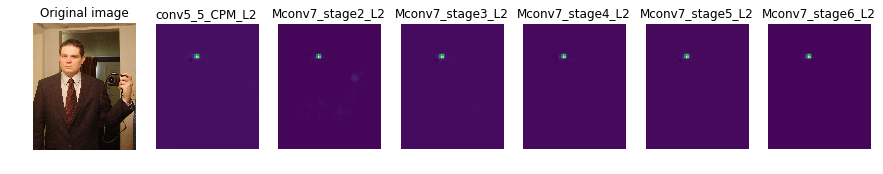

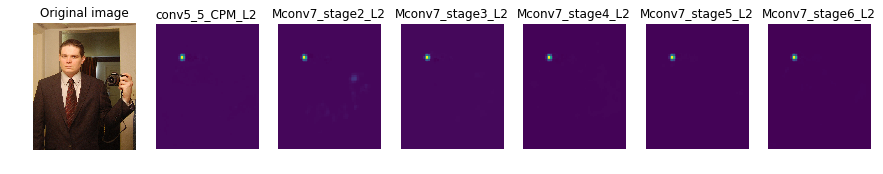

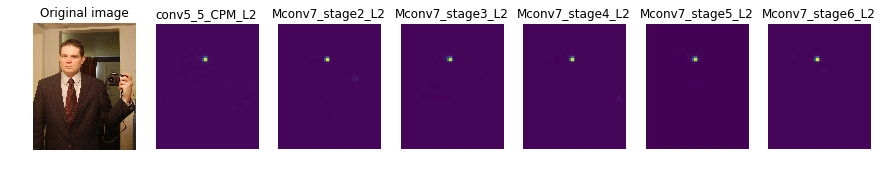

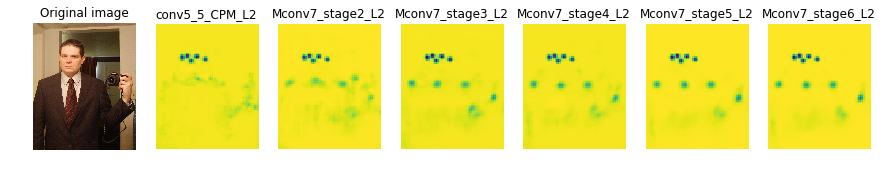

In [3]:
# Read and prepare image
img_fn = OPENPOSE_DIR + '/examples/media/COCO_val2014_000000000459.jpg'
img = plt.imread(img_fn)
img_prep = preproc(img)

# Extract prediction maps
pred_maps = estimate_keypoints(img_prep)

# Compute keypoint coordinates (simplified code for single person)
pose_coords = OrderedDict()
for k in pred_maps:
    # Ignore last map (background). Only include keypoints with probability higher than 0.1
    pose_coords[k] = np.stack([np.unravel_index(p.argmax(), p.shape) for p in pred_maps[k][:-1] if p.max()>0.1])
    
    # Estimation maps are computed at 8x lower resolution than original image. Adjust keypoint coordinates.
    pose_coords[k] = 8 * pose_coords[k]

# Plot keypoints
f, axarr = plt.subplots(1, 7, figsize=(15, 4))
axarr[0].imshow(img)
axarr[0].set_axis_off()
axarr[0].set_title("Original image")
for i, k in enumerate(pred_maps):
    axarr[i + 1].imshow(img)
    axarr[i + 1].set_axis_off()
    axarr[i + 1].set_title(k)
    axarr[i + 1].plot(pose_coords[k][:, 1], pose_coords[k][:, 0], 'o')

# Plot estimation maps
for part in range(19):
    f, axarr = plt.subplots(1, 7, figsize=(15, 4))
    axarr[0].imshow(img)
    axarr[0].set_axis_off()
    axarr[0].set_title("Original image")
    for i, k in enumerate(pred_maps):
        axarr[i + 1].imshow(pred_maps[k][part])
        axarr[i + 1].set_axis_off()
        axarr[i + 1].set_title(k)
